In [168]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import math

import torch
# torch.manual_seed(100)

In [129]:
train_set = pd.read_csv("vaccine_train_set.csv") #read train data set
copy_train = pd. DataFrame(train_set)
train_tweet = train_set['tweet']
train_label = train_set['label']

validation_set = pd.read_csv("vaccine_validation_set.csv") #read validation data set
copy_validation = pd. DataFrame(train_set)
validation_tweet = validation_set['tweet']
validation_label = validation_set['label']


#PREPROCESSING

In [130]:
import numpy as np
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
 
def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    t = tweet.lower() #convert to lower case
    t = re.sub("'", "", t) # to avoid removing contractions in english
    t = re.sub("@[A-Za-z0-9_]+","", t) #removes tags
    t = re.sub("#[A-Za-z0-9_]+","", t) #removes hashtags
    t = re.sub(r'http\S+', '', t) #remove links
    t = re.sub('[()!?]', ' ', t)  #remove punctuation
    # t = re.sub('\[.*?\]',' ', t)
    t = re.sub("[^a-z0-9]"," ", t) #remove numbers
    t = t.split() #splits the tweet to individual words
    # t = [w for w in t if not w in stopwords] #remove stopwords
    t = " ".join(word for word in t)
    return t

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# train_set['tweet'] = train_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
# validation_set['tweet'] = validation_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets

In [ ]:
# rain_set = train_set.drop(train_set[train_set['tweet'].map(lambda x: str(x)=='' )].index)
# validation_set = validation_set.drop(validation_set[validation_set['tweet'].map(lambda x: str(x)=='' )].index)t

In [ ]:
# # train_set['tweet'].filter(lambda x: len(x) > 0).count()
# filtered_train_tweets = [clean_tweet(tw) for tw in train_tweet]
# filtered_validation_tweets = [clean_tweet(tw) for tw in validation_tweet]

#**MODEL 1**

#**VECTORIZATION**

#GloVe

In [4]:
#get Glove files
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-12-23 07:36:14--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-23 07:36:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.10MB/s    in 2m 40s  

2021-12-23 07:38:54 (5.15 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

**Parse the vocabulary and embeddings**


In [827]:
vocabulary,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as glove_file:
# with open('glove.twitter.27B.25d.txt','rt') as glove_file:
    line = glove_file.read().strip().split('\n') #each tweet
for i in range(len(line)):
    i_word = line[i].split(' ')[0] #word
    i_embeddings = [float(val) for val in line[i].split(' ')[1:]] #wrod embandings
    vocabulary.append(i_word)
    embeddings.append(i_embeddings)
# Convert the vocabulary and the embeddings into numpy arrays
vocabulary_npa = np.array(vocabulary)
embeddings_npa = np.array(embeddings)

**Add unknown tokens to the vocab and embeddings arrays**

In case there is a word in our train set that do not exsists in the GloVe vocabulary, that word would be corresponded to an unknown word we added in the vocabulary and the mebendding of this word is retrived from the mean of all existing embeddings.


In [828]:
vocabulary_npa = np.insert(vocabulary_npa, 1, '<unknown>')
unknown_emb_npa = np.mean(embeddings_npa,axis=0,keepdims=True)    #embedding for '<unknown>' token.
embeddings_npa = np.vstack((unknown_emb_npa,embeddings_npa)) #insert embeddings for unknwon token at top of embeddings_npa.

In [829]:
#convert embeddings to a dictionary
dic = {}
for i in range(0,np.size(vocabulary_npa)):
  dic[vocabulary_npa[i]] = i

**Vectorize** **dataset**

Define a class that will be used to vectorise train and validation dataset using Glove.

In [849]:
def flatten(t):
    t = t.reshape(1, -1)
    t = t.squeeze()
    return t

class tweetsDataset(Dataset):
  def __init__(self,train_set,filtered_train_tweets,vocabulary_npa,embeddings_npa):

    #Separate data in features and targets tensors
    # x = torch.tensor(index_pairs, dtype=torch.float)
    tweets = [x.split() for x in filtered_train_tweets] #tokenize tweets tokens = [x.split() for x in filtered_train_tweets]
    
    embedded_tweets = [] #array for embeded tweets->B
    for tweet in tweets: #for each tweet in tokenized_set
      embeded_words = [] #array for embeded words = A
      for word in tweet:#for each word in token
        if word in dic: #if token is in vocabulary -> return index
          embeded_words.append(embeddings_npa[dic[word]]) # A.insert(embeding[index])
        else:
          embeded_words.append(embeddings_npa[dic['<unknown>']]) #A.insert(embedding[0]->unknown)
      embedded_tweets.append(embeded_words)#B.insert[A]
      
    #shrink array 
    mean_tweets = [] 
    for tweet in embedded_tweets: #for tweet in B 
      mean_words = np.mean(tweet,axis=0) #mean(tweet)->insert in C   array.mean(axis=0)
      mean_tweets.append(mean_words)

    #Normalize values
    scaler = MinMaxScaler()
    train_dataset = scaler.fit_transform(np.array(mean_tweets))
    # validation_set = scaler.transform(validation_set.toarray())
    # Apply standartization
    scaler = StandardScaler()
    train_dataset = scaler.fit_transform(np.array(mean_tweets))

    self.x = torch.from_numpy(train_dataset)
    self.y = torch.tensor(train_set['label'], dtype=torch.long)

    self.n_samples = self.x.shape[0]

  def __getitem__(self,index):
    return self.x[index],self.y[index]
  def __len__(self):
    return self.n_samples

# **NEWRAL** **NETWORK**


Defining model class

In [842]:
class my_Network(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(my_Network, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(H2, H3)
        self.relu2 = nn.ReLU()
        self.linear4 = nn.Linear(H3, D_out)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out=self.relu1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        out=self.relu2(out)
        out = self.linear4(out)
        return out

## Train and Evaluate Network

In [850]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#utility function to flaten a list and convert to a numpy array
def convert(array):
  pred_list=[]
  for i in array:
    pred_list.append(i.tolist())
  merged_pred = list(itertools.chain(*pred_list))
  predicted_labels = numpy.array(merged_pred)
  return predicted_labels

Apply prepprocessing to train and validation data.



In [851]:
torch.manual_seed(10)
#filter tweets
train_set['tweet'] = train_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
validation_set['tweet'] = validation_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
#delete emtpy tweets
train_set = train_set.drop(train_set[train_set['tweet'].map(lambda x: str(x)=='' )].index)
validation_set = validation_set.drop(validation_set[validation_set['tweet'].map(lambda x: str(x)=='' )].index)



Initialize the dataloaders.

In [852]:
#Initialize dataloader (Glove)
train_dataset = tweetsDataset(train_set,train_set['tweet'],vocabulary_npa,embeddings_npa)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048, shuffle=True)

validation_dataset = tweetsDataset(validation_set,validation_set['tweet'],vocabulary_npa,embeddings_npa)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=2048, shuffle=True)

Set hyperparameters, layes sizes and load model

In [853]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Define layer sizes
D_in = train_dataset[0][0].shape[0]
print(D_in)
H1 = 246
H2 = 128
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 0.0001

#Initialize model, loss, optimizer
model = my_Network(D_in, H1, H2, H3, D_out).to(device)
# loss_func = nn.MSELoss(reduction='sum')
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

50


**Train and evaluate the network**(GloVe)

For each epoch f1 score and loss function is calculated adn printed. In this step loss scores for ploting curves are also accumulated.

In [856]:
train_loss_history = []
val_loss_history = []
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(20):
  model.train()

  train_batch_losses = []
  val_batch_losses = []

  #train model
  pred_arr=[]
  true_arr=[]
  for x_batch, y_batch in train_dataloader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch.float())
    #store label baches and their prediction to use for f1 calculation
    _, predicted = torch.max(y_pred, 1) #keep the label with the gratest propability
    true_arr.append(y_batch)
    pred_arr.append(predicted)

    loss = loss_func(y_pred, y_batch)#calculate loss
    train_batch_losses.append(loss.item())

    
    optimizer.zero_grad()#Delete previously stored gradients
    loss.backward()#Perform backpropagation starting from the loss calculated in this epoch
    optimizer.step()#Update model's weights based on the gradients calculated during backprop
  
  #modify baches and prediction shape to calculate f1 score
  train_true = convert(true_arr)
  train_pred = convert(pred_arr)

  #########
  #validate
  with torch.no_grad():
    pred_arr=[]
    batch_arr=[]
    for x_batch, y_batch in validation_dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model(x_batch.float())
      _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability
      pred_label_array = predicted.detach().numpy() #tranform form tensor to numpy for f1

      #loss calculation per batch
      # t = flatten(y_batch) #cors entropy with indices as paramters
      val_loss = loss_func(y_pred, y_batch)
      val_batch_losses.append(loss.item())
      #store baches and their prediction to use for f1 calculation
      batch_arr.append(y_batch)
      pred_arr.append(predicted)
  
  #modify baches and prediction shape to calculate f1 score
  val_true = convert(batch_arr)
  val_pred = convert(pred_arr)
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')

  #calculate loss
  train_loss = sum(train_batch_losses)/len(train_dataloader)
  val_loss = sum(val_batch_losses)/len(validation_dataloader)
  print("F1 SCORE(train): ", f1_train ,"  F1 SCORE(validation): ", f1_val)
  print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print("\n")

  #store loss or each epoch
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader))

F1 SCORE(train):  0.5279431803376722   F1 SCORE(validation):  0.5231889346332125
LOSS(train):  0.9071356058120728  LOSS(validation):  0.9084628820419312


F1 SCORE(train):  0.5309549454980492   F1 SCORE(validation):  0.5186396619864969
LOSS(train):  0.8990936502814293  LOSS(validation):  0.8942467570304871


F1 SCORE(train):  0.5362213450844362   F1 SCORE(validation):  0.5266195702680447
LOSS(train):  0.8932365253567696  LOSS(validation):  0.9002835154533386


F1 SCORE(train):  0.5352638921452804   F1 SCORE(validation):  0.5209811980649682
LOSS(train):  0.88649682700634  LOSS(validation):  0.8838687539100647


F1 SCORE(train):  0.5400073916919549   F1 SCORE(validation):  0.5315372203536579
LOSS(train):  0.8819874674081802  LOSS(validation):  0.9052183628082275


F1 SCORE(train):  0.5425488630433316   F1 SCORE(validation):  0.527891480082435
LOSS(train):  0.8750278353691101  LOSS(validation):  0.863649308681488


F1 SCORE(train):  0.5435251965963517   F1 SCORE(validation):  0.5278568020

##LEARNING CURVES

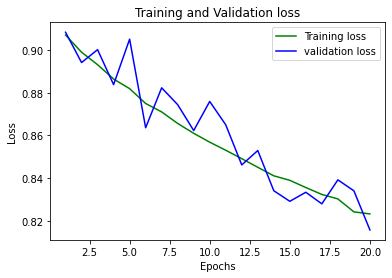

In [857]:
import matplotlib.pyplot as plt
# loss_train = history.history['train_loss']
# loss_val = history.history['val_loss']
epochs = range(1,21)
# loss in train_loss_history
plt.plot(epochs, train_loss_history, 'g', label='Training loss')
plt.plot(epochs, val_loss_history, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#**Model 2**

#BOW VECTORIZATION


In [946]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(10)

In [947]:
from sklearn import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler

bow_vectorizer = CountVectorizer(ngram_range=(1,2), min_df=0.007)

In [948]:
class tweetsDataset(Dataset):
  def __init__(self,data,bow_data):

    #Separate data in features and targets tensors
    y_df = pd.DataFrame(data, columns=[data.columns[-1]])
    
    #Save in tensors
    self.x = torch.tensor(bow_data, dtype=torch.float)
    self.y = torch.tensor(data['label'], dtype=torch.long)

    self.n_samples = self.x.shape[0]

  def __getitem__(self,index):
    return self.x[index],self.y[index]
  def __len__(self):
    return self.n_samples

Define network class

In [949]:
class my_Network(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(my_Network, self).__init__()
        
        self.linear1 = nn.Linear(D_in, H1)
        self.dropout1 = nn.Dropout(p=0.2)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(H1, H2)
        self.dropout2 = nn.Dropout(p=0.2)
        self.linear3 = nn.Linear(H2, H3)
        # self.dropout3 = nn.Dropout(p=0.2)
        self.relu2 = nn.ReLU()
        self.linear4 = nn.Linear(H3, D_out)
        # self.relu3 = nn.ReLU()
        # self.soft = nn.Softmax()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out=self.relu1(out)
        out = self.linear2(out)
        out = self.dropout2(out)
        out = self.linear3(out)
        # out = self.dropout2(out)
        out=self.relu2(out)
        out = self.linear4(out)
        # out=self.relu3(out)
        # out=self.soft(out)
        # out = self.linear3(out)
        # out = self.linear4(out)
        return out

Apply prepprocessing to train and validation data.


In [950]:
#filter tweets
train_set['tweet'] = train_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
validation_set['tweet'] = validation_set['tweet'].apply(lambda tw: clean_tweet(tw)) #clean tweets
#delete emtpy tweets
train_set = train_set.drop(train_set[train_set['tweet'].map(lambda x: str(x)=='' )].index)
validation_set = validation_set.drop(validation_set[validation_set['tweet'].map(lambda x: str(x)=='' )].index)
#vectorize data
bow_trainset = bow_vectorizer.fit_transform(train_set['tweet']) #apply BOW on training tweets
bow_validationset = bow_vectorizer.transform(validation_set['tweet']) #apply BOW on validation tweets
#Normalize values
scaler = MinMaxScaler()
bow_trainset = scaler.fit_transform(bow_trainset.toarray())
bow_validationset = scaler.transform(bow_validationset.toarray())
# Apply standartization
scaler = StandardScaler()
bow_trainset = scaler.fit_transform(bow_trainset)
bow_validationset = scaler.transform(bow_validationset)

Initialize dataloaders

In [951]:
#Initialize dataloader (BOW)
train_dataset = tweetsDataset(train_set,bow_trainset)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048, shuffle=True)

validation_dataset = tweetsDataset(validation_set,bow_validationset)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=2048, shuffle=True)

Set hyperparameters, layes sizes and load model

In [952]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#Define layer sizes
D_in = train_dataset[0][0].shape[0]
H1 = 256
H2 = 128
H3 = 32
D_out = 3

#Define Hyperparameters
learning_rate = 0.001 

#Initialize model, loss, optimizer
model = my_Network(D_in, H1, H2, H3, D_out).to(device)
# model.to(device)
loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

**Train and evaluate the network** (BOW)

For each epoch f1 score and loss function is calculated and printed. In this step loss scores for ploting curves are also accumulated.

In [953]:
def flatten(t):
  flat_list = []
  for sublist in t:
    for item in sublist:
        flat_list.append(item)
  return flat_list

from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [954]:
train_loss_history = []
val_loss_history = []
roc_history = []
f1_total_train = 0
f1_total_val = 0

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
for epoch in range(10):
  model.train()

  train_batch_losses = []
  val_batch_losses = []

  #train model
  pred_arr=[]
  true_arr=[]
  for x_batch, y_batch in train_dataloader:

    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)

    y_pred = model(x_batch.float())
    #store label baches and their prediction to use for f1 calculation
    _, predicted = torch.max(y_pred, 1) #keep the label with the gratest propability
    true_arr.append(y_batch)
    pred_arr.append(predicted)

    loss = loss_func(y_pred, y_batch)#calculate loss
    train_batch_losses.append(loss.item())
    
    optimizer.zero_grad()#Delete previously stored gradients
    loss.backward() #Perform backpropagation starting from the loss calculated in this epoch
    optimizer.step()#Update model's weights based on the gradients calculated during backprop

  #modify baches and prediction shape to calculate f1 score
  train_true = convert(true_arr)
  train_pred = convert(pred_arr)

  #########
  #validate
  with torch.no_grad():
    pred_arr=[]
    batch_arr=[]
    # bin_pred = []
    # bin_true = []
    for x_batch, y_batch in validation_dataloader:
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
      y_pred = model(x_batch.float())

      _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability
      pred_label_array = predicted.detach().numpy() #tranform form tensor to numpy for f1

      #loss calculation per batch
      val_loss = loss_func(y_pred, y_batch)
      val_batch_losses.append(loss.item())
      
      #store baches and their prediction to use for f1 calculation
      batch_arr.append(y_batch)
      pred_arr.append(predicted)

  #modify baches and prediction shape to calculate f1 score
  val_true = convert(batch_arr)
  val_pred = convert(pred_arr)
  precision_train = precision_score(train_true, train_pred, average='weighted')
  recall_train = recall_score(train_true, train_pred, average='weighted')
  f1_train = f1_score(train_true, train_pred, average='weighted')
  f1_total_train += f1_train 

  precision_val = precision_score(val_true, val_pred, average='weighted')
  recall_val = recall_score(val_true, val_pred, average='weighted')
  f1_val = f1_score(val_true, val_pred, average='weighted')
  f1_total_val += f1_val 

  #calculate losses 
  train_loss = sum(train_batch_losses)/len(train_dataloader)
  val_loss = sum(val_batch_losses)/len(validation_dataloader)
  print("PRESISION(train): ", precision_train ,"  PRESISION(validation): ", precision_val)
  print("RECALL(train): ", recall_train ,"  RECALL(validation): ", recall_val)
  print("F1 SCORE(train): ", f1_train ,"  F1 SCORE(validation): ", f1_val)
  print("LOSS(train): ", train_loss, " LOSS(validation): ", val_loss )
  print("\n")


  #store loss or each epoch (used in learning curves )
  train_loss_history.append(sum(train_batch_losses)/len(train_dataloader))
  val_loss_history.append(sum(val_batch_losses)/len(validation_dataloader))
print("overall train scpre:", f1_total_train/10)
print("overall validation score: ", f1_total_val/10)



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRESISION(train):  0.5204192266719253   PRESISION(validation):  0.5486021961923326
RECALL(train):  0.4025460930640913   RECALL(validation):  0.5559947299077734
F1 SCORE(train):  0.4279594046706728   F1 SCORE(validation):  0.5080813701488266
LOSS(train):  1.0594656392931938  LOSS(validation):  0.980828583240509




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PRESISION(train):  0.5455587107510983   PRESISION(validation):  0.5574945687519766
RECALL(train):  0.6197792549855763   RECALL(validation):  0.6420729029424681
F1 SCORE(train):  0.5783890299835981   F1 SCORE(validation):  0.5961154255362294
LOSS(train):  0.908647894859314  LOSS(validation):  0.8773536086082458


PRESISION(train):  0.6999183357086486   PRESISION(validation):  0.6567801469297733
RECALL(train):  0.6565909946067979   RECALL(validation):  0.6565656565656566
F1 SCORE(train):  0.6098252436733675   F1 SCORE(validation):  0.6116462483388609
LOSS(train):  0.7917922809720039  LOSS(validation):  0.7792151570320129


PRESISION(train):  0.6931777373404708   PRESISION(validation):  0.6641063379215847
RECALL(train):  0.6788536310046407   RECALL(validation):  0.6723759332454985
F1 SCORE(train):  0.6373367447570519   F1 SCORE(validation):  0.6345648640563714
LOSS(train):  0.7368858158588409  LOSS(validation):  0.7187426686286926


PRESISION(train):  0.695272551894863   PRESISION(validat

#LEARNING CURVES

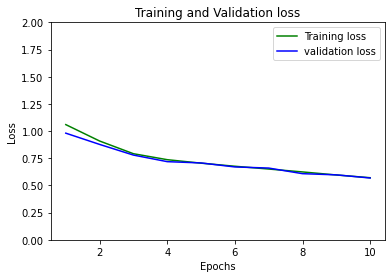

In [955]:
import matplotlib.pyplot as plt
# loss_train = history.history['train_loss']
# loss_val = history.history['val_loss']
epochs = range(1,11)
# loss in train_loss_history
plt.ylim([0, 2])
plt.plot(epochs, train_loss_history, 'g', label='Training loss')
plt.plot(epochs, val_loss_history, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#ROC CURVES

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


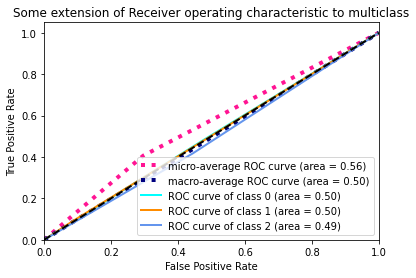

In [960]:
#calculate ROC
pred_arr = []
n_calsses=3
for x_batch, y_batch in validation_dataloader:
  x_batch = x_batch.to(device)
  y_batch = y_batch.to(device)
  y_pred = model(x_batch.float())

  _, predicted = torch.max(y_pred, 1)#keep the label with the greatest propability
    #store baches and their prediction to use for f1 calculation
  pred_arr.append(predicted)
total_pred = model(torch.from_numpy(bow_trainset).float())
total_pred.shape
y_true_binarized = label_binarize(validation_set['label'].tolist(), classes=[0,1,2])
y_pred_binarized = label_binarize(flatten(pred_arr), classes=[0,1,2])

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), y_pred_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

